# 1. Loading Essential Libraries 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

## 2.1 Defining Data Split Function

In [2]:
data_dir = 'C:/Users/RELYMER/Downloads/deeplearning/data_even'
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=400)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=400)
    print('Total Images: ', len(train_data) + len(test_data))
    print("Images for Training:",len(train_data))
    print("Images for Testing:",len(test_data))
    return trainloader, testloader
trainloader, testloader = load_split_train_test(data_dir, .2)
print('\nRaces in the Dataset:\t', trainloader.dataset.classes)

Total Images:  64000
Images for Training: 32000
Images for Testing: 32000

Races in the Dataset:	 ['african', 'asian', 'caucasian', 'indian']


## 2.2 Checking GPU status to utelize

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

## 2.3 Loading Resnet Model from Pytorch

In [4]:
model = models.resnet50(pretrained=True)

## 2.4 Defining new layers on top of model

In [5]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 4),
                                 nn.LogSoftmax(dim=1))

## 3. Setting Loss Function and Optimizer

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#Sending model to gpu
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 4. Training loop

In [7]:
epochs = 10
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals =top_class == labels.view(*top_class.shape)
                    accuracy +=torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))
            print('Training data length',len(trainloader))
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()


Training data length 64
Epoch 1/10.. Train loss: 1.400.. Test loss: 1.390.. Test accuracy: 0.257
Training data length 64
Epoch 1/10.. Train loss: 1.380.. Test loss: 1.368.. Test accuracy: 0.343
Training data length 64
Epoch 1/10.. Train loss: 1.357.. Test loss: 1.340.. Test accuracy: 0.419
Training data length 64
Epoch 1/10.. Train loss: 1.331.. Test loss: 1.312.. Test accuracy: 0.485
Training data length 64
Epoch 1/10.. Train loss: 1.303.. Test loss: 1.286.. Test accuracy: 0.504
Training data length 64
Epoch 1/10.. Train loss: 1.277.. Test loss: 1.262.. Test accuracy: 0.520
Training data length 64
Epoch 2/10.. Train loss: 1.259.. Test loss: 1.238.. Test accuracy: 0.542
Training data length 64
Epoch 2/10.. Train loss: 1.231.. Test loss: 1.215.. Test accuracy: 0.568
Training data length 64
Epoch 2/10.. Train loss: 1.211.. Test loss: 1.192.. Test accuracy: 0.568
Training data length 64
Epoch 2/10.. Train loss: 1.190.. Test loss: 1.169.. Test accuracy: 0.569
Training data length 64
Epoch 

In [12]:
torch.save(model, 'even_data_color_img.pth')

In [13]:
len(train_losses)

64

## 5. Ploting Training and Validation Loss

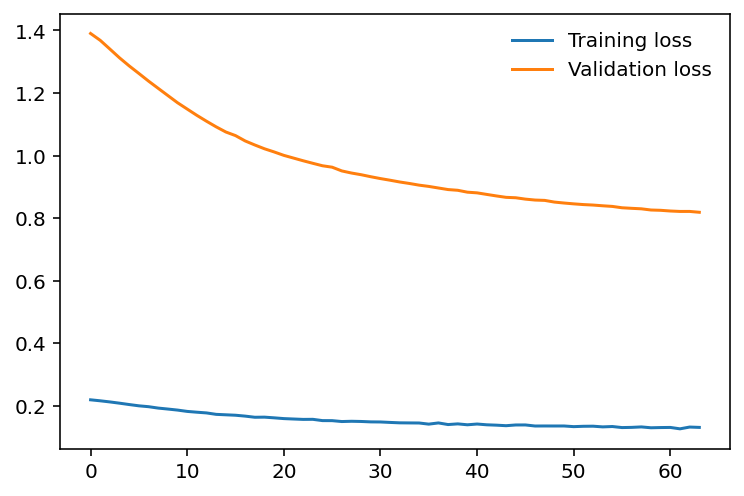

In [14]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

# 6. Model Inference

In [15]:
data_dir = 'C:/Users/RELYMER/Downloads/deeplearning/data_even'
test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                     ])

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('even_data_color_img.pth')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    #input = Variable(image_tensor, requires_grad)
    input=image_tensor.detach()
    #input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [18]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

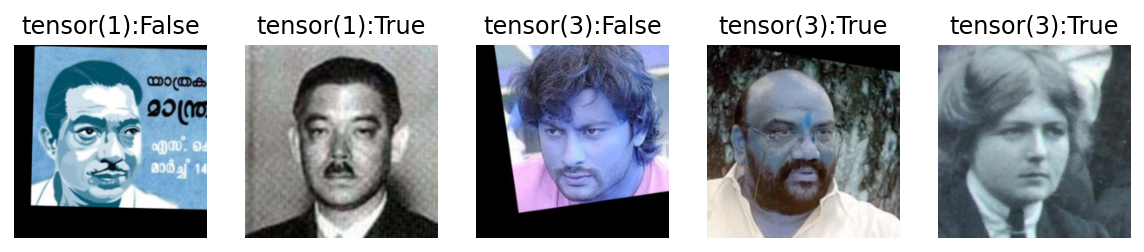

In [19]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(labels[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

## 7. Top one and top five errors

In [20]:
def evaluteTop1(model, loader):
    model.eval()
    
    correct = 0
    total = len(loader.dataset)

    for x,y in loader:
        x,y = x.to(device), y.to(device)
        with torch.no_grad():
            logits = model(x)
            pred = logits.argmax(dim=1)
            correct += torch.eq(pred, y).sum().float().item()
        #correct += torch.eq(pred, y).sum().item()
    return correct / total

def evaluteTop5(model, loader):
    model.eval()
    correct = 0
    total = len(loader.dataset)
    for x, y in loader:
        x,y = x.to(device),y.to(device)
        with torch.no_grad():
            logits = model(x)
            maxk = max((1,5))
            y_resize = y.view(-1,1)
            _, pred = logits.topk(maxk, 1, True, True)
            correct += torch.eq(pred, y_resize).sum().float().item()
    return correct / total

In [21]:
evaluteTop1(model, testloader)

0.13359375

In [ ]:
evaluteTop5(model, testloader)